In [32]:
import pandas as pd
import fiftyone as fo

import seaborn as sns

sns.set_theme(style='darkgrid', palette='mako')

## Label distribution in ROV dataset

In [33]:
def make_df(dataset, splits):
    """Counts how many annotations of each label exist per split.

    Args:
        dataset (fiftyone dataset): Fiftyone dataset.
        splits (list): List of splits in the fiftyone dataset. E.g.: ['train', 'test']

    Returns:
        pandas DataFrame: label, count and split columns.
    """    
    df_list = []
    for i in splits:
        view = dataset.match_tags(i)
        count_dict = view.count_values("ground_truth.detections.label")

        df = pd.DataFrame(count_dict.items(), columns=['label', 'count']).copy()
        df["split"] = i
        df_list.append(df)
    
    return pd.concat(df_list)

In [34]:
rov_dataset = fo.load_dataset("rov")

In [35]:
label_count = make_df(rov_dataset, ["train", "val", "test"])
label_count.head()

# save label counts
# label_count.to_csv("../results/label_count_split.csv", index=False)

,label,count,split
0,Mysida,46,train
1,Medusae,2708,train
2,Anemone,22,train
3,Fish,4398,train
4,Echinoderm,553,train


/tmp/ipykernel_32555/1711040779.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  label_dist.set_xticklabels(label_dist.get_xticklabels(), rotation=45, horizontalalignment='right');


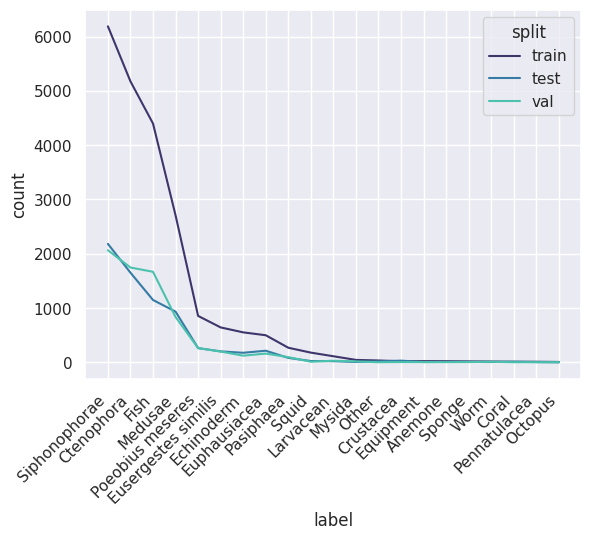

In [36]:
# sort by count, more labels first
sorted_df = label_count.sort_values(by='count', ascending=False)

# plot label counts
label_dist = sns.lineplot(data=sorted_df, x="label", y="count", hue="split", palette="mako")
label_dist.set_xticklabels(label_dist.get_xticklabels(), rotation=45, horizontalalignment='right');

## AUV models evaluation

In [37]:
auv_results = pd.read_csv('../artifacts/results/auv_results.csv')

In [38]:
auv_results.columns

Index(['model', 'auv_train_sample_count', 'training_time', 'val_image_count',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'fitness', 'preprocess', 'inference', 'loss',
       'postprocess'],
      dtype='object')

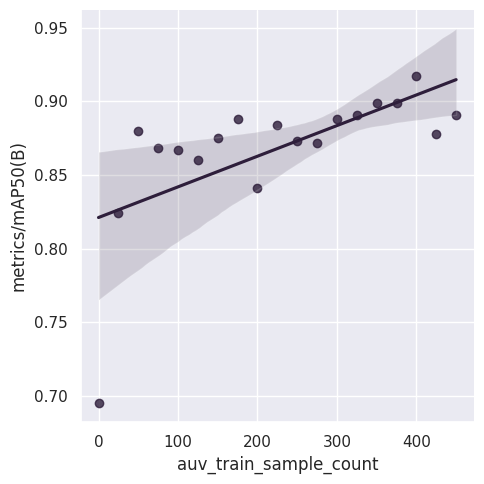

In [39]:
sns.lmplot(y='metrics/mAP50(B)', x='auv_train_sample_count', data=auv_results, fit_reg=True);

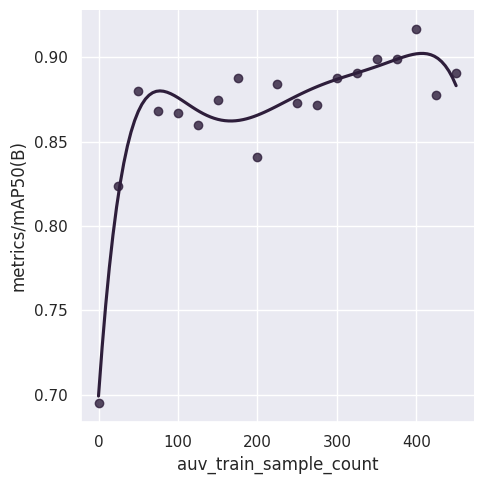

In [55]:
sns.lmplot(y='metrics/mAP50(B)', x='auv_train_sample_count', data=auv_results, fit_reg=True, order=6, ci=None);

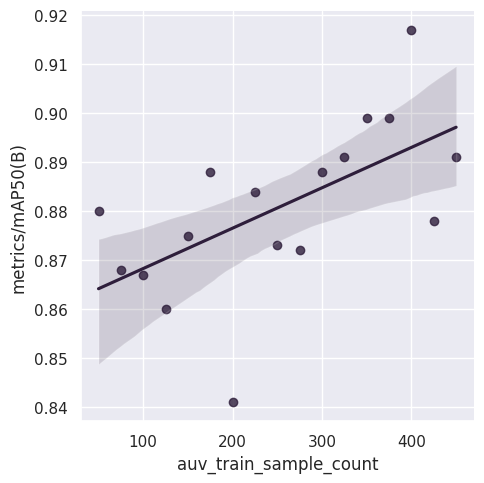

In [50]:
exclude = auv_results[auv_results['auv_train_sample_count'] > 49]
sns.lmplot(y='metrics/mAP50(B)', x='auv_train_sample_count', data=exclude, fit_reg=True);

## Uniqueness vs mAP50 vs sample count

In [ ]:
# code used to generate this analysis

# import re

# my_list = list(auv_dataset.count_sample_tags())
# regex = re.compile(r"train\d+")

# result = list(filter(regex.search, my_list))
# print(result)

# sample_tags = result

# auv_dataset = fo.load_dataset("auv")

# for i in sample_tags:
#     mean = auv_dataset.match_tags(i).mean("uniqueness")
#     std = auv_dataset.match_tags(i).std("uniqueness")
#     # quantiles = auv_dataset.match_tags(i).quantiles("uniqueness", [0.25, 0.5, 0.75, 0.9])

#     print(f"{i} {mean} {std}")

In [42]:
uniq = pd.read_csv('/mnt/c/Users/sabri/Documents/github/thesis/artifacts/results/uniq_increasing_random.csv', index_col=0)

In [51]:
uniq

,sample_count,uniqueness_mean,uniqueness_std,eusergestes_mAP50
dataset,,,,
train25,25,0.109739,0.058574,0.824
train50,50,0.122406,0.107924,0.880
train75,75,0.134749,0.133491,0.868
train100,100,0.111558,0.088248,0.867
train125,125,0.124337,0.109796,0.860
train150,150,0.131300,0.120946,0.875
train175,175,0.126387,0.122678,0.888
train200,200,0.126088,0.114973,0.841
train225,225,0.136456,0.130602,0.884


Only measures linear correlation.

- The correlation coefficient ranges from −1 to 1. An absolute value of exactly 1 implies that a linear equation describes the relationship between X and Y perfectly, with all data points lying on a line. 
- The correlation sign is determined by the regression slope: a value of +1 implies that all data points lie on a line for which Y increases as X increases, and vice versa for −1.
- A value of 0 implies that there is no linear dependency between the variables.

In [43]:
uniq.corr("pearson")

,sample_count,uniqueness_mean,uniqueness_std,eusergestes_mAP50
sample_count,1.000000,0.178870,0.324607,0.676478
uniqueness_mean,0.178870,1.000000,0.930992,0.291702
uniqueness_std,0.324607,0.930992,1.000000,0.485763
eusergestes_mAP50,0.676478,0.291702,0.485763,1.000000


Intuitively, the Kendall correlation between two variables will be high when observations have a similar (or identical for a correlation of 1) rank (i.e. relative position label of the observations within the variable: 1st, 2nd, 3rd, etc.) between the two variables, and low when observations have a dissimilar (or fully different for a correlation of −1) rank between the two variables.

The Kendall rank coefficient is often used as a test statistic in a statistical hypothesis test to establish whether two variables may be regarded as statistically dependent. This test is non-parametric, as it does not rely on any assumptions on the distributions of X or Y or the distribution of (X,Y).

In [44]:
uniq.corr("kendall")

,sample_count,uniqueness_mean,uniqueness_std,eusergestes_mAP50
sample_count,1.000000,0.071895,0.124183,0.541281
uniqueness_mean,0.071895,1.000000,0.843137,-0.066010
uniqueness_std,0.124183,0.843137,1.000000,0.013202
eusergestes_mAP50,0.541281,-0.066010,0.013202,1.000000


How well the distribution follows a monotonic function.

If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

In [45]:
uniq.corr("spearman")

,sample_count,uniqueness_mean,uniqueness_std,eusergestes_mAP50
sample_count,1.000000,0.083591,0.155831,0.719381
uniqueness_mean,0.083591,1.000000,0.960784,-0.047545
uniqueness_std,0.155831,0.960784,1.000000,0.060982
eusergestes_mAP50,0.719381,-0.047545,0.060982,1.000000


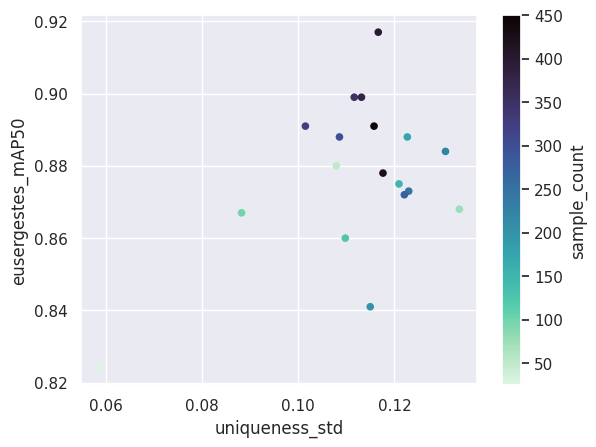

In [46]:
uniq.plot.scatter(x='uniqueness_std', y='eusergestes_mAP50', c='sample_count', colormap='mako_r');

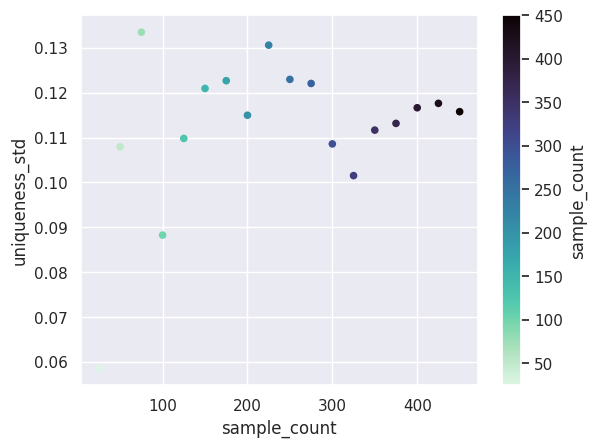

In [47]:
uniq.plot.scatter(y='uniqueness_std', x='sample_count', c='sample_count', colormap='mako_r');

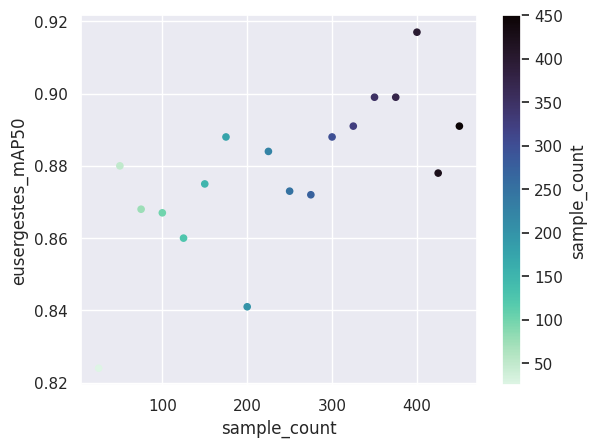

In [48]:
uniq.plot.scatter(y='eusergestes_mAP50', x='sample_count', c='sample_count', colormap='mako_r');


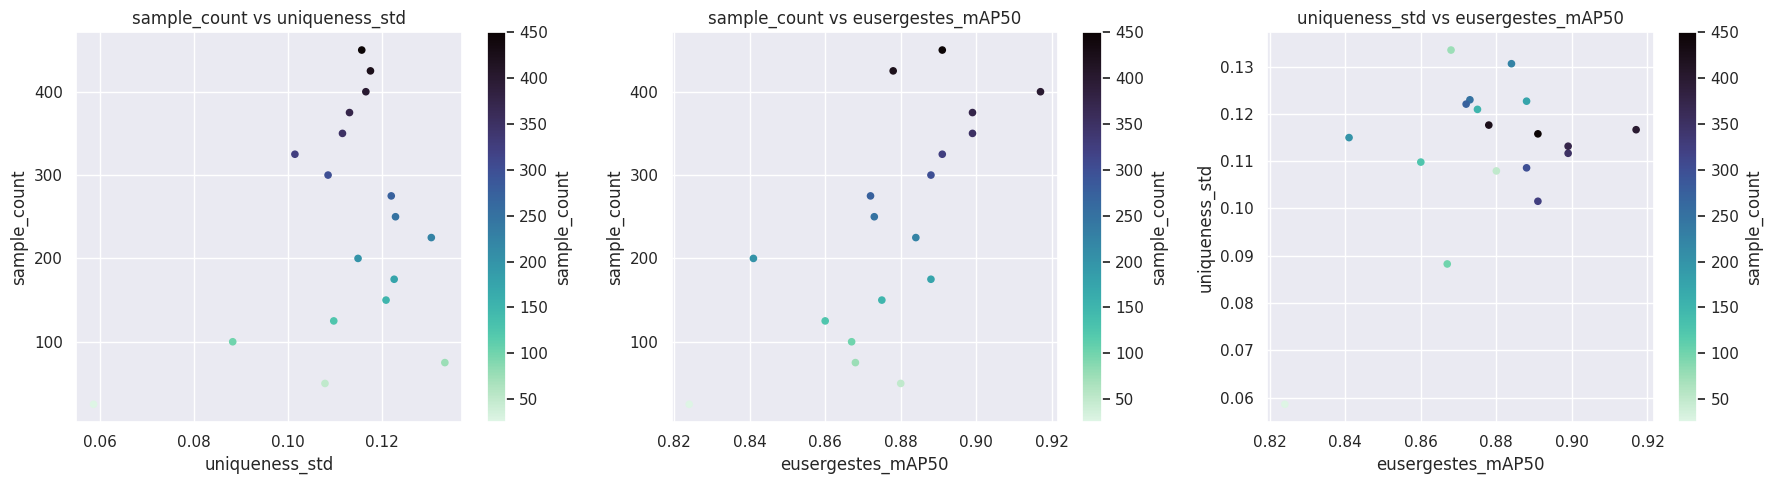

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'uniq'

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot the scatter plots in their respective subplots
uniq.plot.scatter(y='uniqueness_std', x='eusergestes_mAP50', c='sample_count', colormap='mako_r', ax=axes[2])
uniq.plot.scatter(x='uniqueness_std', y='sample_count', c='sample_count', colormap='mako_r', ax=axes[0])
uniq.plot.scatter(x='eusergestes_mAP50', y='sample_count', c='sample_count', colormap='mako_r', ax=axes[1])

# Set the titles for each subplot
axes[2].set_title('uniqueness_std vs eusergestes_mAP50')
axes[0].set_title('sample_count vs uniqueness_std')
axes[1].set_title('sample_count vs eusergestes_mAP50')

# Display the plots
plt.tight_layout()
plt.show()
